# Minplus algebra experiment

This code attempts to learn the 8D mixture prior
$J(x) = \max_{i \in \{1,...,m\}} \{<p_i^{true},x>\}$
assuming we have access to training data $\{y_i, S(y_i)\} = \max_{i \in \{1,...,m\}} \{<p_i^{true},x> - t \theta_i^{true} - \gamma_i^{true}\}$.

## Import modules 

In [1]:
import os
import numpy as np
import torch

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import seaborn as sns

from network import LPN
from lib.utils import cvx
from lib.invert import invert

# set location
MODEL_DIR = "experiments/models/minplus_4_1_3_8D"
os.makedirs(MODEL_DIR, exist_ok=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# set random seeds
np.random.seed(1)
torch.manual_seed(1)

# plotting options
plt.rcParams.update({"text.usetex": False})
sns.set_theme()

## Parameters

In [2]:

# --- Parameters for Sec 4.1.3---
dim_41 = 8  # Example dimension (e.g., 2D, 4D, 8D as in the paper)
m_41 = 4   # Example number of neurons (e.g., 2 or 4 as in the paper)
data_points_41 = 20000 # Example number of data points
iterations_41 = 100000 # Reduced iterations for demonstration
a_41 = 4 # Grid limit for sampling y_j if using uniform
spacing = 500


# LPN model parameters
beta = 10       # beta of softplus
hidden = 128     # number of hidden units
layers = 6      # number of layers

# optimization algorithm to use for computing the prior (cvx_cg, cvx_gd)
INVERT_MODE = "cvx_gd"

# === Section 4.1: Cases 3 ===

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch 

def inner_prod(x, y):
    return np.sum(x * y, axis=1)

def euclid_norm_sq(x):
    return np.sum(x * x, axis=1)

def hjsol_true_case3(y_points, p_true_vectors,t=1.0):
    m = p_true_vectors.shape[0]
    N = y_points.shape[0]
    s_values = np.zeros((N, m))
    theta_true_i = -0.5 * euclid_norm_sq(p_true_vectors)
    for i in range(m):
        s_values[:, i] = inner_prod(y_points, p_true_vectors[i, :]) - t*theta_true_i[i]
    return np.max(s_values, axis=1)

def prior_true_case3(y_points, p_true_vectors):
    m = p_true_vectors.shape[0]
    N = y_points.shape[0]
    j_values = np.zeros((N, m))
    for i in range(m):
        j_values[:, i] = inner_prod(y_points, p_true_vectors[i, :])
    return np.max(j_values, axis=1)

def cvx_true_case3(y_points, p_true_vectors):
    s_y_1 = hjsol_true_case3(y_points, p_true_vectors)
    psi_y = 0.5 * euclid_norm_sq(y_points) - s_y_1
    return psi_y



# --- Functions for evaluating the learned LPN model (adapted from notebook) ---

def invert_prior(x, model, INVERT_MODE):
    """ 
    This function inverts the learned prior at a set of query points x.
    That is, we compute the points y for which nabla_{y}psi(y) = x, 
    where nabla_{y}psi denotes the gradient of the LPN network.
    
    Args:
        x (np.ndarray): A numpy array of real numbers at which to invert the prior.
        model: The trained LPN model object.
        INVERT_MODE: The method for inverting the LPN network.

    Returns:
        np.ndarray: The (approximate) set of points y for which nabla_{y}psi(y) = x.
    """
    y = invert(x,model,INVERT_MODE)
    return y

def evaluate_learned_prior_case3(x_eval_points, y_inverted_points, model):
    """ 
    This function evaluates the learned prior J_est(x_eval_points) using the LPN.
    It uses y_inverted_points where x_eval_points = nabla_psi(y_inverted_points).
    The formula used is J_est(x) = <x, y> - 0.5 * ||x||^2 - psi(y)
    
    Args:
        x_eval_points (np.ndarray): N x dim array of points at which to estimate the prior J(x).
        y_inverted_points (np.ndarray): N x dim_psi array of points y such that x_eval_points = nabla_psi(y_inverted_points).
                                       dim_psi is the input dimension to the LPN.
        model: The trained LPN model object (e.g., a torch.nn.Module).

    Returns:
        np.ndarray: N-dimensional array of estimated prior values J_est(x_eval_points).
    """
    # Ensure y_inverted_points is a torch tensor for model input
    try:
        y_tensor = torch.from_numpy(y_inverted_points).float().to(device)
        psi_of_y_inverted = model.scalar(y_tensor).squeeze(1).detach().cpu().numpy()
    except NameError: # device might not be defined if torch is not fully set up
        print("Warning: 'device' not defined. Assuming CPU for evaluate_learned_prior.")
        y_tensor = torch.from_numpy(y_inverted_points).float()
        psi_of_y_inverted = model.scalar(y_tensor).squeeze(1).detach().numpy()
    

    # Formula: J_est(x) = <x,y> - 0.5*||x||^2 - psi(y)
    # Changed to 0.5 * euclid_norm_sq(x) which is 0.5 * ||x||^2.
    prior_est = inner_prod(x_eval_points, y_inverted_points) - 0.5 * euclid_norm_sq(x_eval_points) - psi_of_y_inverted
    
    return prior_est

# --- Plotting tools (Modified) ---

def compute_square_cross_sections(a, spacing, dim):
    ''' Compute the cross sections (xi,0,...,0) and (0,xi,0,...,0) 
    on the grid [-a,a]^{dim} along the first and second dimensions.
    '''
    xi = np.linspace(-a, a, spacing)
    grid = np.zeros((xi.size, dim))
    x1_0_points = np.copy(grid)
    x1_0_points[:, 0] = xi
    
    x2_0_points = np.copy(grid)
    if dim > 1: # Ensure we don't try to access index 1 if dim is 1
        x2_0_points[:, 1] = xi
    elif dim == 1: # For 1D, x2_0_points is not really a "second axis" cross-section
        x2_0_points = x1_0_points.copy() # Or handle as appropriate for 1D plots

    return xi, x1_0_points, x2_0_points


def cross_sections_plots_case3(model, a, spacing, p_true_vectors, INVERT_MODE, dim):
    ''' 
    Compare the true functions for Case 3 vs the LPN model
    on a square grid [-a,a]^{dim} by overlaying their cross sections 
    along the first and (if dim > 1) second axes.

    Args:
        model: The trained LPN model object.
        a: Measure of the grid [-a,a]^{dim}.
        spacing: Number of points in the interval [-a,a].
        p_true_vectors (np.ndarray): m x dim array of true p_i vectors for Case 3.
        INVERT_MODE: The method for inverting the LPN network.
        dim: Spatial dimension of the problem.
    '''
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)

    # Compute the true psi (cvx_true) and prior (prior_true) for Case 3
    x1_0_psi_true = cvx_true_case3(x1_0_points, p_true_vectors)
    x1_0_J_true = prior_true_case3(x1_0_points, p_true_vectors)

    if dim > 1:
        x2_0_psi_true = cvx_true_case3(x2_0_points, p_true_vectors)
        x2_0_J_true = prior_true_case3(x2_0_points, p_true_vectors)
    else: # For 1D, use the same points for "second" axis plot or omit
        x2_0_psi_true = x1_0_psi_true 
        x2_0_J_true = x1_0_J_true


    # Compute the learned psi and prior from the LPN model
    x1_0_psi_est = cvx(x1_0_points, model) # LPN directly learns/outputs psi
    y1_inverted = invert_prior(x1_0_points, model, INVERT_MODE)
    x1_0_J_est = evaluate_learned_prior_case3(x1_0_points, y1_inverted, model)

    if dim > 1:
        x2_0_psi_est = cvx(x2_0_points, model)
        y2_inverted = invert_prior(x2_0_points, model, INVERT_MODE)
        x2_0_J_est = evaluate_learned_prior_case3(x2_0_points, y2_inverted, model)
    else:
        x2_0_psi_est = x1_0_psi_est
        x2_0_J_est = x1_0_J_est


    # Plot cross sections of the convex function psi(y)
    plt.figure() # Use plt.figure() for new plot
    plt.plot(xi, x1_0_psi_est, "-", ms=5, label="LPN (Learned $\psi$)")
    plt.plot(xi, x1_0_psi_true, "--", ms=5, label="True $\psi$ (Case 3)") # Changed to dashed for true
    plt.grid(True) # Use boolean for grid
    plt.title(f"Cross sections ($\psi(y_1,0,...)$) - Dim {dim}, Case 3")
    plt.xlabel('$y_1$')
    plt.ylabel('$\psi(y_1,0,...)$')
    plt.legend()
    plt.show()

    if dim > 1:
        plt.figure()
        plt.plot(xi, x2_0_psi_est, "-", ms=5, label="LPN (Learned $\psi$)")
        plt.plot(xi, x2_0_psi_true, "--", ms=5, label="True $\psi$ (Case 3)")
        plt.grid(True)
        plt.title(f"Cross sections ($\psi(0,y_2,0,...)$) - Dim {dim}, Case 3")
        plt.xlabel('$y_2$')
        plt.ylabel('$\psi(0,y_2,0,...)$')
        plt.legend()
        plt.show()

    # Plot cross sections of the prior function J(x)
    # Note: The x-axis here represents the components of x_eval_points,
    # which are the same as y_points for these cross-sections.
    plt.figure()
    plt.plot(xi, x1_0_J_est, "-", label="LPN (Learned $J$)")
    plt.plot(xi, x1_0_J_true, "--", label="True $J$ (Case 3)")
    plt.grid(True)
    plt.title(f"Cross sections ($J(x_1,0,...)$) - Dim {dim}, Case 3")
    plt.xlabel('$x_1$')
    plt.ylabel('$J(x_1,0,...)$')
    plt.legend()
    plt.show()

    if dim > 1:
        plt.figure()
        plt.plot(xi, x2_0_J_est, "-", label="LPN (Learned $J$)")
        plt.plot(xi, x2_0_J_true, "--", label="True $J$ (Case 3)")
        plt.grid(True)
        plt.title(f"Cross sections ($J(0,x_2,0,...)$) - Dim {dim}, Case 3")
        plt.xlabel('$x_2$')
        plt.ylabel('$J(0,x_2,0,...)$')
        plt.legend()
        plt.show()


def plot_all_case3(model, a, spacing, p_true_vectors, INVERT_MODE, dim):
    """
    Wrapper to plot cross sections for Case 3.
    """
    print(f"\n--- Plotting Cross Sections for Case 3 (Dim={dim}) ---")
    cross_sections_plots_case3(model, a, spacing, p_true_vectors, INVERT_MODE, dim)

In [4]:
# Helper functions

print("\n--- Reproducing Section 4.1: Cases 3 ---")

def exp_func(x, gamma):
    ''' Proximal matching loss -- x |-> 1 - exp(-(||x||_{2}^{2}/gamma)^{2})
        for training learned proximal networks.
    '''
    return -torch.exp(-((torch.linalg.vector_norm(x, ord = 2, dim = 1)/ gamma) ** 2)) + 1.0

# --- Generate p_true (randomly in [-1, 1)^n) ---
p_true_41 = np.random.uniform(-1, 1, (m_41, dim_41))
print(f"Generated p_true_41 (shape {p_true_41.shape})")


--- Reproducing Section 4.1: Cases 3 ---
Generated p_true_41 (shape (4, 8))


# --- Generate Training Data (using Moreau envelope target as per notebook) ---

In [5]:
# --- Generate Training Data (using Moreau envelope target as per notebook) ---
# Sample y_j points (uniformly on [-a, a]^n grid)
y_j_41= np.zeros((dim_41,data_points_41))

if(dim_41>1):
    for k in range(0,dim_41):
        y_j_41[k] = np.random.uniform(-a_41,a_41,data_points_41)
else:
    y_j_41 = np.random.uniform(-a_41,a_41,data_points_41)

#y_j_41 = np.random.uniform(-a_41, a_41, data_points_41)
y_j_41 = y_j_41.reshape(data_points_41,dim_41)
# Compute the Moreau envelope at the sampled y_j points
cvx_samples_c3 =cvx_true_case3(y_j_41, p_true_41)
cvx_samples_c3 = cvx_samples_c3.reshape(-1, 1) # Reshape for loss calculation
# Recast the samples as tensors
y_j_41 = torch.from_numpy(y_j_41).float()
cvx_samples_c3 = torch.from_numpy(cvx_samples_c3).float()

# --- ADD THIS TO MOVE DATA TO GPU ---
y_j_41 = y_j_41.to(device)
cvx_samples_c3 = cvx_samples_c3.to(device)

## Training function

In [6]:
def single_iteration(i, data_points, lpn_model, optimizer,input,cvx_samples,loss_type, gamma_loss=None):
    # Compute the convex function from the input.
    cvx_out = lpn_model.scalar(input)

    # Calculate the loss function
    if loss_type == 2:
        loss = (cvx_out - cvx_samples).pow(2).sum() / data_points # MSE loss
    elif loss_type == 1:
        loss = (cvx_out - cvx_samples).abs().sum() / data_points    # MAE loss
    elif loss_type == 0:
        loss = exp_func(cvx_out - cvx_samples, gamma_loss).mean()   # proximal matching loss
    else:
        raise ValueError("loss_type must be 0, 1, or 2")


    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    lpn_model.wclip()

    # monitor
    # loss_lstar = exp_func(out - target, 0.1).mean()

    if not i % 5000:
        print("iteration", i, "loss", loss.item()) #, "loss_lstar", loss_lstar.item())

# Train

L2 loss -- Train

In [7]:

# --- Train LPN for Case 3 ---
print("--- Training LPN for Case 3 ---")
lpn_model_c3 = LPN(in_dim=dim_41, hidden=50, layers=5, beta=10,eps=1e-3).to(device)
optimizer_c3 = torch.optim.Adam(lpn_model_c3.parameters(), lr=1e-4)

for i in range(1):
     single_iteration(i, data_points_41, lpn_model_c3, optimizer_c3, y_j_41,cvx_samples_c3,loss_type=2,gamma_loss=None) # Using MSE

for g in optimizer_c3.param_groups:
    g["lr"] = 1e-4
for i in range(iterations_41):
    single_iteration(i, data_points_41, lpn_model_c3, optimizer_c3, y_j_41,cvx_samples_c3,loss_type=2,gamma_loss=None)

# Save the model for Case 3
# save the model
torch.save(lpn_model_c3.state_dict(), os.path.join(MODEL_DIR, "Case3_l2.pth"))

--- Training LPN for Case 3 ---
iteration 0 loss 311.7546081542969
iteration 0 loss 86.86304473876953
iteration 5000 loss 0.32895970344543457
iteration 10000 loss 0.11017553508281708
iteration 15000 loss 0.0749685987830162
iteration 20000 loss 0.0625181794166565
iteration 25000 loss 0.05600731819868088
iteration 30000 loss 0.05152985826134682
iteration 35000 loss 0.048038169741630554
iteration 40000 loss 0.04559049755334854
iteration 45000 loss 0.04359433427453041
iteration 50000 loss 0.04190157726407051
iteration 55000 loss 0.04046343266963959
iteration 60000 loss 0.03905028849840164
iteration 65000 loss 0.03776468336582184
iteration 70000 loss 0.036440879106521606
iteration 75000 loss 0.03522093966603279
iteration 80000 loss 0.03451167419552803
iteration 85000 loss 0.03286174684762955
iteration 90000 loss 0.031875040382146835
iteration 95000 loss 0.030775118619203568


L2 loss -- Plot


--- Plotting Cross Sections for Case 3 (Dim=8) ---
loss -439.2679443359375
loss -1544.106201171875
loss -2368.357421875
loss -2767.994873046875
loss -3020.122802734375
loss -3210.77685546875
loss -3351.4697265625
loss -3440.331787109375
loss -3489.5341796875
loss -3516.75634765625
loss -3531.14990234375
loss -3538.063232421875
loss -3540.948486328125
loss -3541.9423828125
loss -3542.20947265625
loss -3542.26220703125
loss -3542.268798828125
loss -3542.27001953125
loss -3542.27001953125
loss -3542.26953125
loss -3542.26953125
loss -3542.27001953125
loss -3542.27001953125
loss -3542.269775390625
loss -3542.27001953125
loss -3542.27001953125
loss -3542.269775390625
loss -3542.27001953125
loss -3542.27001953125
loss -3542.269775390625
loss -3542.27001953125
loss -3542.269775390625
loss -3542.269775390625
loss -3542.27001953125
loss -3542.27001953125
loss -3542.26953125
loss -3542.26953125
loss -3542.27001953125
loss -3542.269775390625
loss -3542.269775390625
final mse:  2.2368147334361765

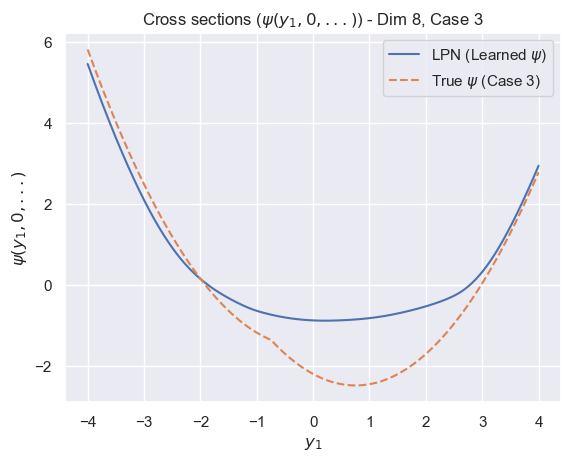

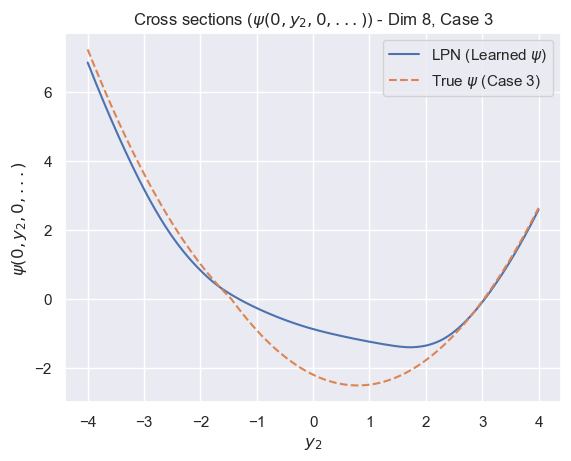

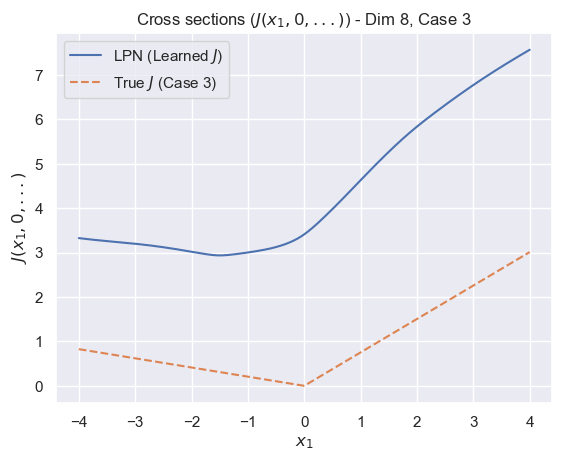

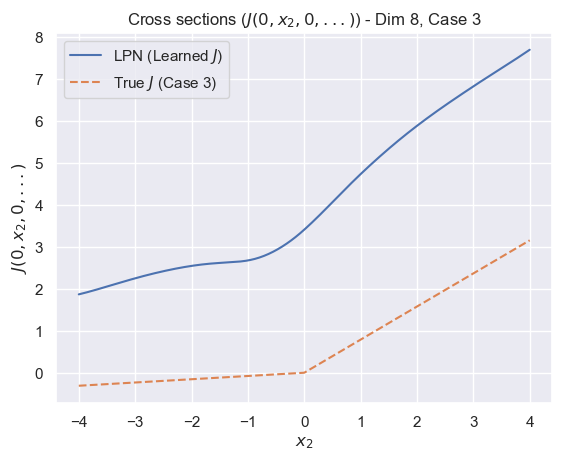

In [8]:
plot_all_case3(lpn_model_c3, a_41, spacing, p_true_41, INVERT_MODE, dim_41)

In [ ]:
# --- Generate New Training Data for the Second LPN G(x) ---
# We use the same x_j_exp_tensor as the first LPN's training data for x_k
x_k_tensor = y_j_41.clone().to(device)
x_k_tensor.requires_grad_(True)

# 1. Compute the gradient y_k = grad_x psi_theta(x_k, t=1)
# Get psi(x_k)
psi_x_k = lpn_model_c3.scalar(x_k_tensor)

# Get gradient y_k = grad_psi(x_k)
y_k_tensor = lpn_model_c3(x_k_tensor)

# 2. Evaluate the "new" samples G_k = <y_k, x_k> - psi_theta(x_k, 1) (from eq 26)
inner_prod_yk_xk = torch.sum(y_k_tensor * x_k_tensor, dim=1, keepdim=True)
G_samples_tensor_with_graph = inner_prod_yk_xk - psi_x_k

# Detach the tensor to treat G_k as fixed targets, breaking the connection
# to the first LPN's graph and preventing the RuntimeError during training.
G_samples_tensor = G_samples_tensor_with_graph.detach().to(device) 

# The input tensor x_k_tensor is still needed for the second LPN training,
# but it should also not require a gradient for that training.
x_k_tensor = x_k_tensor.detach()
x_k_tensor.requires_grad_(False) 
y_k_tensor = y_k_tensor.detach()
y_k_tensor.requires_grad_(False)
# G_samples_tensor now holds the target values G_k
print(f"Generated G samples: G_samples_tensor shape {G_samples_tensor.shape}")

# --- Step 3: Train LPN G(x) ---
print("\n--- Training Second LPN G(x) for Concave Quadratic Prior ---")
# The target for this LPN is G_samples_tensor
# The input for this LPN is x_k_tensor
lpn_model_G = LPN(in_dim=dim_41, hidden=hidden, layers=layers, beta=beta, eps=1e-3).to(device)
optimizer_G = torch.optim.Adam(lpn_model_G.parameters(), lr=1e-4)

# Initial shorter training phase
for i in range(1):
     single_iteration(i, data_points_41, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=2, gamma_loss=None)

for g in optimizer_G.param_groups:
    g["lr"] = 1e-4 # Use a smaller learning rate for the long phase
for i in range(iterations_41):
    single_iteration(i, data_points_41, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=2, gamma_loss=None)

torch.save(lpn_model_G.state_dict(), os.path.join(MODEL_DIR, "G_network_l2.pth"))
print("Training of LPN for G(x) complete and model saved.")

Generated G samples: G_samples_tensor shape torch.Size([20000, 1])

--- Training Second LPN G(x) for Concave Quadratic Prior ---
iteration 0 loss 566.5660400390625
iteration 0 loss 535931.8125
iteration 5000 loss 9.851577758789062
iteration 10000 loss 7.262853145599365
iteration 15000 loss 0.843435525894165
iteration 20000 loss 0.11014482378959656
iteration 25000 loss 0.04629727452993393
iteration 30000 loss 0.0338083915412426
iteration 35000 loss 0.027754466980695724
iteration 40000 loss 0.02394006960093975
iteration 45000 loss 0.02140832506120205
iteration 50000 loss 0.01949167624115944
iteration 55000 loss 0.01785973645746708
iteration 60000 loss 0.01662823185324669
iteration 65000 loss 0.015598048456013203
iteration 70000 loss 0.01471539307385683
iteration 75000 loss 0.013991865329444408
iteration 80000 loss 0.013285842724144459
iteration 85000 loss 0.012777887284755707
iteration 90000 loss 0.01218127366155386
iteration 95000 loss 0.011712237261235714
Training of LPN for G(x) compl


--- Plotting Estimated Prior J(x) from G(x) Network ---


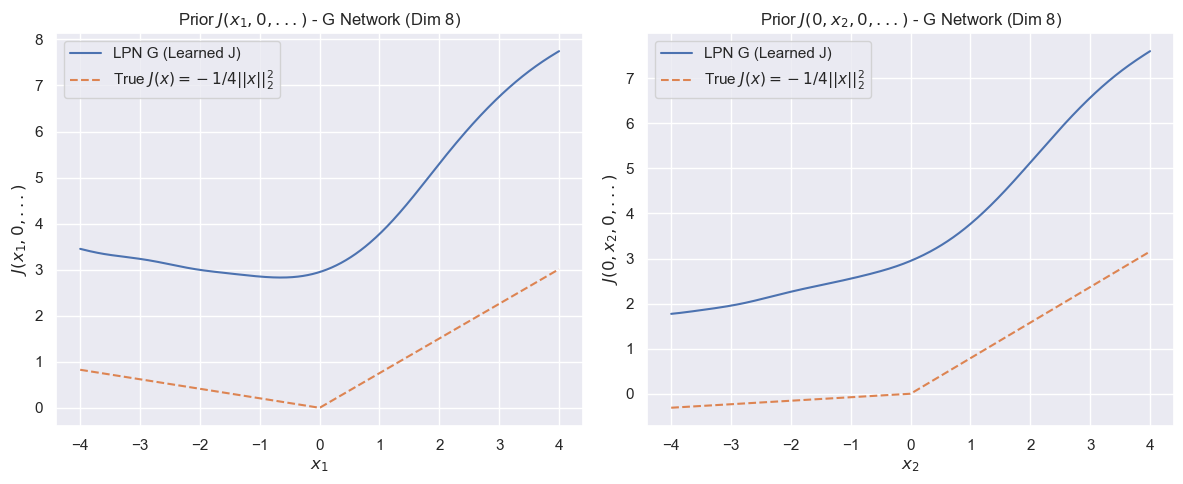

In [10]:
def evaluate_learned_J_G_network(x_points, model_G):
    """
    Evaluates the learned prior J(x) using the trained G(x) network.
    J(x) = G(x) - 0.5 * ||x||^2
    """
    # Convert to tensor
    x_tensor = torch.from_numpy(x_points).float().to(device)
    
    # Get G(x) from the second LPN model
    G_x = model_G.scalar(x_tensor)
    
    # Compute 0.5 * ||x||^2
    x_norm_sq_np = euclid_norm_sq(x_points)
    x_norm_sq_tensor = torch.from_numpy(x_norm_sq_np).float().to(device).reshape(-1, 1)

    # Apply the formula: J_est = G(x) - 0.5 * ||x||^2
    J_est = G_x - 0.5 * x_norm_sq_tensor
    
    # Convert back to numpy
    J_est_np = J_est.detach().cpu().numpy().flatten()
    
    return J_est_np

def plot_J_G_network(model_G, a, spacing, dim,p_true_vectors):
    """Plots the cross-sections of the estimated prior J(x) from the G network."""
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)
    # True Prior
    x1_0_J_true = prior_true_case3(x1_0_points, p_true_vectors)
    if dim > 1:
        x2_0_J_true = prior_true_case3(x2_0_points, p_true_vectors)
    else:
        x2_0_J_true = x1_0_J_true
        
    # Estimated Prior from G(x) Network
    x1_0_J_G_est = evaluate_learned_J_G_network(x1_0_points, model_G)
    if dim > 1:
        x2_0_J_G_est = evaluate_learned_J_G_network(x2_0_points, model_G)
    else:
        x2_0_J_G_est = x1_0_J_G_est
    
    print("\n--- Plotting Estimated Prior J(x) from G(x) Network ---")
    plt.figure(figsize=(12,5))
    
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_J_G_est, "-", label="LPN G (Learned J)")
    plt.plot(xi, x1_0_J_true, "--", label="True $J(x)=-1/4||x||_2^2$")
    plt.grid(True)
    plt.title(f"Prior $J(x_1,0,...)$ - G Network (Dim {dim})")
    plt.xlabel('$x_1$')
    plt.ylabel('$J(x_1,0,...)$')
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_J_G_est, "-", label="LPN G (Learned J)")
        plt.plot(xi, x2_0_J_true, "--", label="True $J(x)=-1/4||x||_2^2$")
        plt.grid(True)
        plt.title(f"Prior $J(0,x_2,0,...)$ - G Network (Dim {dim})")
        plt.xlabel('$x_2$')
        plt.ylabel('$J(0,x_2,0,...)$')
        plt.legend()
    plt.tight_layout()
    plt.savefig('G_network_prior_plot.png')
    
# --- Execute Plotting ---
plot_J_G_network(lpn_model_G, a_41, spacing, dim_41, p_true_41)

L1 loss -- Train

In [ ]:
# --- Train LPN for Case 3 ---
print("--- Training LPN for Case 3 ---")
lpn_model_c3 = LPN(in_dim=dim_41, hidden=50, layers=4, beta=10,eps=1e-3).to(device)
optimizer_c3 = torch.optim.Adam(lpn_model_c3.parameters(), lr=1e-3)

for i in range(1):
     single_iteration(i, data_points_41, lpn_model_c3, optimizer_c3, y_j_41,cvx_samples_c3,loss_type=1,gamma_loss=None)

for g in optimizer_c3.param_groups:
    g["lr"] = 1e-4
for i in range(iterations_41):
    single_iteration(i, data_points_41, lpn_model_c3, optimizer_c3, y_j_41,cvx_samples_c3,loss_type=1,gamma_loss=None)

# Save the model for Case 3
# save the model
torch.save(lpn_model_c3.state_dict(), os.path.join(MODEL_DIR, "Case3_l1.pth"))

--- Training LPN for Case 3 ---
iteration 0 loss 16.70073699951172
iteration 0 loss 6.376964092254639
iteration 5000 loss 0.3170042634010315
iteration 10000 loss 0.265727162361145
iteration 15000 loss 0.2460668385028839
iteration 20000 loss 0.23437844216823578
iteration 25000 loss 0.22591491043567657
iteration 30000 loss 0.2198306918144226
iteration 35000 loss 0.21527604758739471
iteration 40000 loss 0.21094253659248352
iteration 45000 loss 0.20707634091377258
iteration 50000 loss 0.20379644632339478
iteration 55000 loss 0.20169395208358765
iteration 60000 loss 0.19867411255836487
iteration 65000 loss 0.1968706250190735
iteration 70000 loss 0.19486381113529205
iteration 75000 loss 0.19299617409706116
iteration 80000 loss 0.19157595932483673


L1 loss -- Plot


--- Plotting Cross Sections for Case 3 (Dim=8) ---
loss -582.470458984375
loss -1327.98583984375
loss -1921.916015625
loss -2362.8896484375
loss -2688.93505859375
loss -2935.6533203125
loss -3110.2900390625
loss -3222.123046875
loss -3286.88427734375
loss -3320.87060546875
loss -3336.8779296875
loss -3343.5458984375
loss -3345.9482421875
loss -3346.66845703125
loss -3346.8369140625
loss -3346.865234375
loss -3346.86865234375
loss -3346.86865234375
loss -3346.86865234375
loss -3346.86865234375
loss -3346.86865234375
loss -3346.86865234375
loss -3346.86865234375
loss -3346.86865234375
loss -3346.86865234375
loss -3346.86865234375
loss -3346.86865234375
loss -3346.86865234375
loss -3346.86865234375
loss -3346.86865234375
loss -3346.86865234375
loss -3346.86865234375
loss -3346.86865234375
loss -3346.86865234375
loss -3346.86865234375
loss -3346.86865234375
loss -3346.86865234375
loss -3346.86865234375
loss -3346.86865234375
loss -3346.86865234375
final mse:  4.4602835314044853e-10
max, m

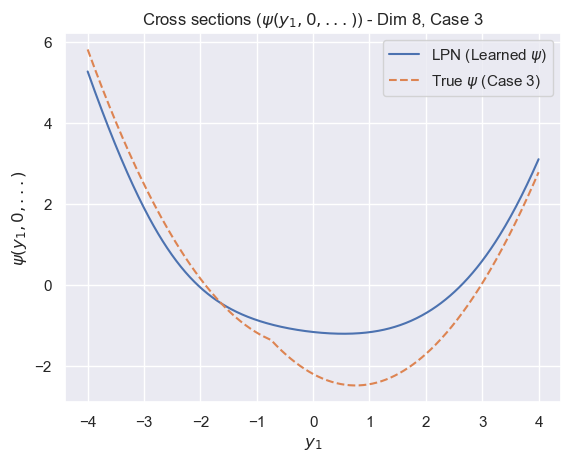

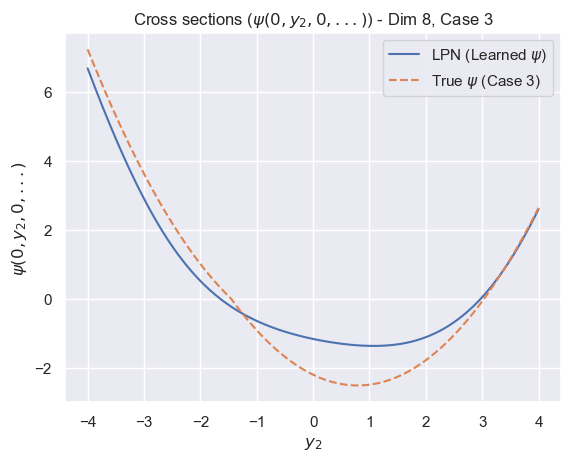

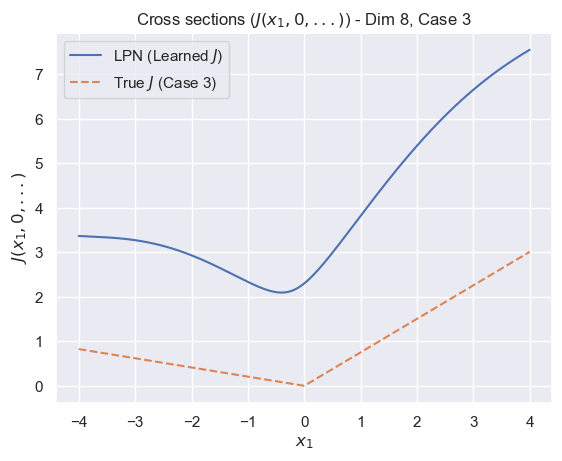

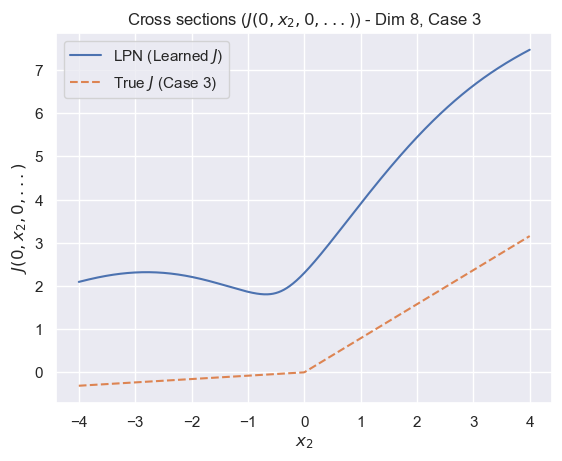

In [10]:
plot_all_case3(lpn_model_c3, a_41, spacing, p_true_41, INVERT_MODE, dim_41)

Proximal matching loss.
We perform proximal matching loss with a decreasing sequence of gamma parameters.

gamma = 20 -- Train

In [11]:
# lpn_model = LPN(in_dim=dim, hidden=hidden, layers=layers, beta=beta).to(device)
# optimizer = torch.optim.Adam(lpn_model.parameters(), lr=1e-3)

# loss_type = 0
# gamma_loss = 20

# # set learning rate
# for g in optimizer.param_groups:
#     g["lr"] = 1e-4

# for i in range(3000):
#     single_iteration(i, data_points, lpn_model, optimizer, loss_type, gamma_loss)

# for g in optimizer.param_groups:
#     g["lr"] = 1e-5

# for i in range(3000):
#     single_iteration(i, data_points, lpn_model, optimizer, loss_type, gamma_loss)

# torch.save(lpn_model.state_dict(), os.path.join(MODEL_DIR, f"l_{gamma_loss}.pth"))

gamma = 20 -- Plot

In [12]:
# plot_all(lpn_model,a,spacing,mu1,mu2,sigma1,sigma2,INVERT_MODE,dim)

gamma = 12.5 -- Train

In [13]:
# gamma_loss = 12.5

# for g in optimizer.param_groups:
#     g["lr"] = 1e-5

# for i in range(6000):
#     single_iteration(i, data_points, lpn_model, optimizer, loss_type, gamma_loss)

# torch.save(lpn_model.state_dict(), os.path.join(MODEL_DIR, f"l_{gamma_loss}.pth"))

gamma = 12.5 -- Plot

In [14]:
# plot_all(lpn_model,a,spacing,mu1,mu2,sigma1,sigma2,INVERT_MODE,dim)

gamma = 10 -- Train

In [15]:
# gamma_loss = 10

# for g in optimizer.param_groups:
#     g["lr"] = 1e-5

# for i in range(10000):
#     single_iteration(i, data_points, lpn_model, optimizer, loss_type, gamma_loss)

# torch.save(lpn_model.state_dict(), os.path.join(MODEL_DIR, f"l_{gamma_loss}.pth"))

gamma = 10 -- Plot

In [16]:
# plot_all(lpn_model,a,spacing,mu1,mu2,sigma1,sigma2,INVERT_MODE,dim)